# ***Home Loan Approval Prediction Project***
Section: **2**  Group: **14**
Project Overview

# **Section 1: Import Modules and Models from sklearn**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# **Section 2: Data Preparation**

In [ ]:
df = pd.read_csv('loan-train-extended.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (853, 13)

First 5 rows:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         

# **Exploratory Data Analysis (EDA)**


Missing values in each column:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


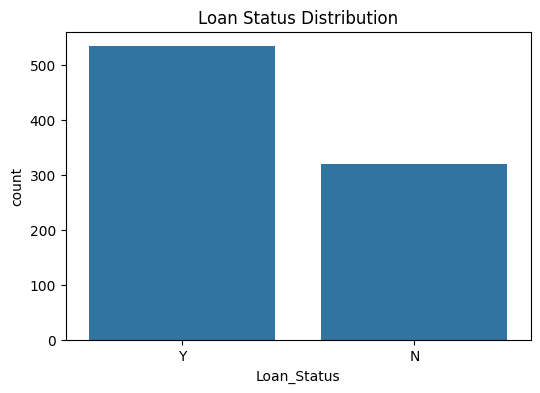

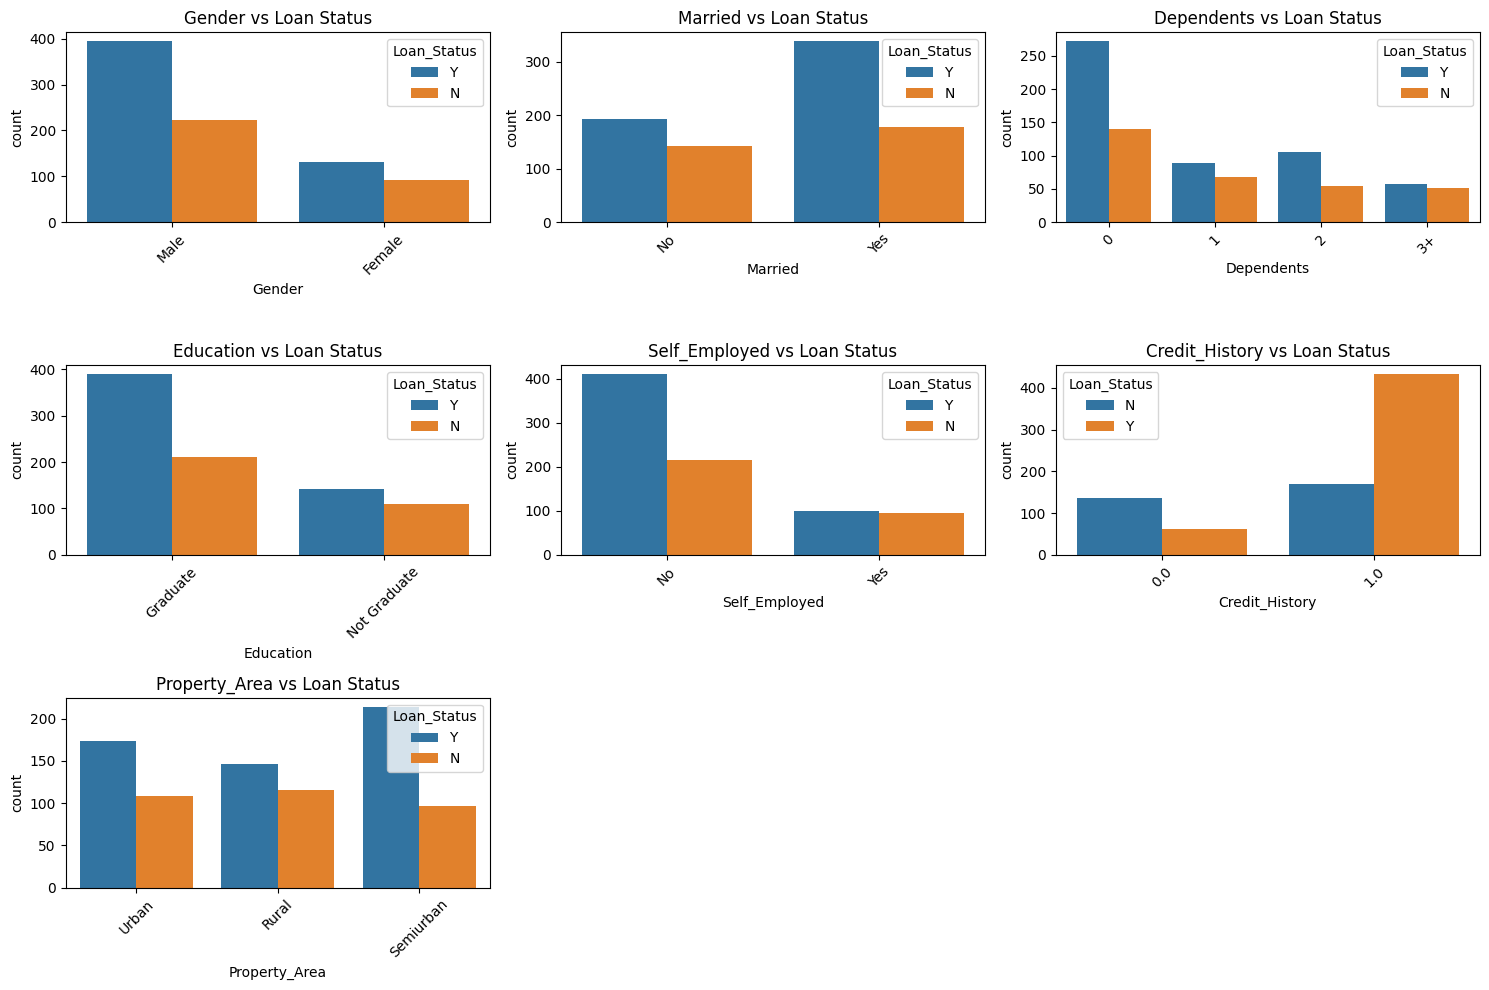

<Figure size 1500x1000 with 0 Axes>

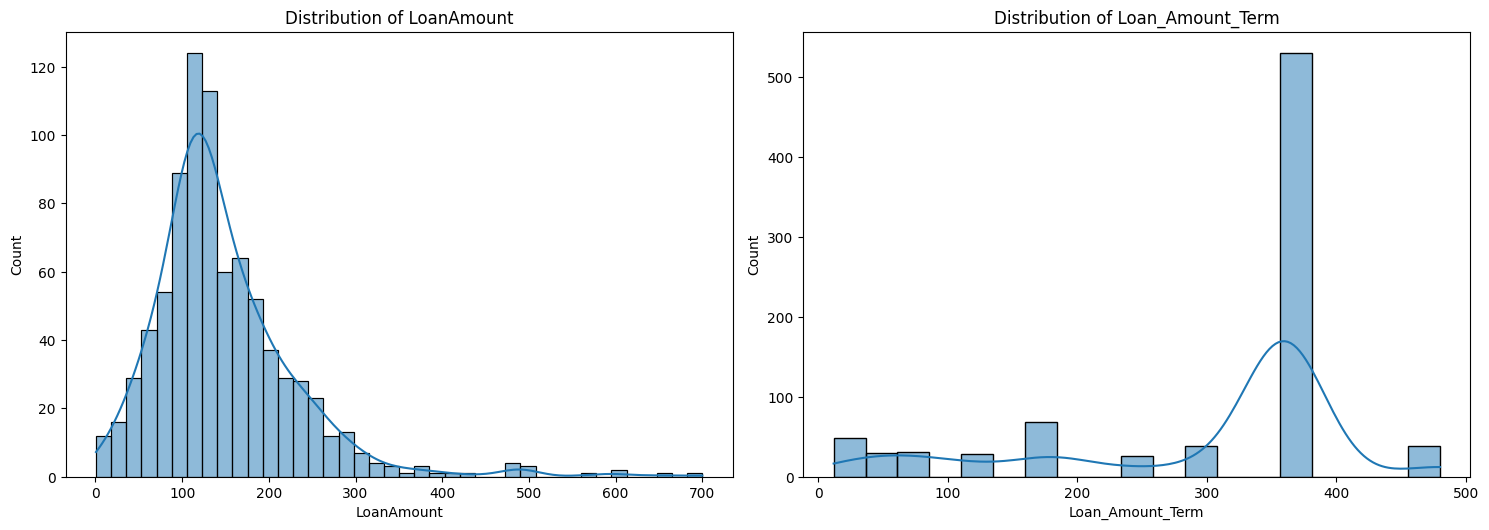

In [ ]:
print("\nMissing values in each column:")
print(df.isnull().sum())

# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=df)
plt.title('Loan Status Distribution')
plt.show()

# Visualize categorical features
plt.figure(figsize=(15, 10))
cat_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

for i, feature in enumerate(cat_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, hue='Loan_Status', data=df)
    plt.title(f'{feature} vs Loan Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize numerical features
plt.figure(figsize=(15, 10))
num_features = ['LoanAmount', 'Loan_Amount_Term']


# Distribution of numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


# **Data processing**

In [ ]:
df_processed = df.copy()

# Remove Loan_ID as it's just an identifier
df_processed = df_processed.drop('Loan_ID', axis=1)

# Convert Loan_Status to numeric (Y=1, N=0)
df_processed['Loan_Status'] = df_processed['Loan_Status'].map({'Y': 1, 'N': 0})

# Total Income
df_processed['TotalIncome'] = df_processed['ApplicantIncome'] + df_processed['CoapplicantIncome']

# Replace missing values
# For categorical features
cat_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for feature in cat_features:
    df_processed[feature] = df_processed[feature].fillna(df_processed[feature].mode()[0])

# For numerical features
num_features = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for feature in num_features:
    df_processed[feature] = df_processed[feature].fillna(df_processed[feature].median())

# Encode categorical variables
for feature in cat_features:
    le = LabelEncoder()
    df_processed[feature] = le.fit_transform(df_processed[feature])

# Check the processed dataframe
print("\nProcessed dataframe info:")
print(df_processed.info())
print("\nFirst 5 rows of processed data:")
print(df_processed.head())


Processed dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             853 non-null    int64  
 1   Married            853 non-null    int64  
 2   Dependents         853 non-null    int64  
 3   Education          853 non-null    int64  
 4   Self_Employed      853 non-null    int64  
 5   ApplicantIncome    853 non-null    int64  
 6   CoapplicantIncome  853 non-null    float64
 7   LoanAmount         853 non-null    float64
 8   Loan_Amount_Term   853 non-null    float64
 9   Credit_History     853 non-null    float64
 10  Property_Area      853 non-null    int64  
 11  Loan_Status        853 non-null    int64  
 12  TotalIncome        853 non-null    float64
dtypes: float64(5), int64(8)
memory usage: 86.8 KB
None

First 5 rows of processed data:
   Gender  Married  Dependents  Education  Self_Employed  A

In [ ]:
# Split dataset into features and target
X = df_processed.drop('Loan_Status', axis=1)
y = df_processed['Loan_Status']

# Apply feature selection
selector = SelectKBest(f_classif, k=8)  # Select top 8 features
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features_idx = selector.get_support(indices=True)
selected_features = X.columns[selected_features_idx]

print("\nSelected features:")
print(selected_features)

# Create dataset with selected features
X_selected = X[selected_features]

print("\nFeature importance scores:")
for feature, score in zip(selected_features, selector.scores_[selected_features_idx]):
    print(f"{feature}: {score:.4f}")


Selected features:
Index(['Married', 'Dependents', 'Education', 'Self_Employed',
       'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History',
       'TotalIncome'],
      dtype='object')

Feature importance scores:
Married: 5.8819
Dependents: 3.7615
Education: 5.4793
Self_Employed: 15.0290
CoapplicantIncome: 5.6377
Loan_Amount_Term: 15.4451
Credit_History: 122.0653
TotalIncome: 2.6249


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (682, 8)
Testing set shape: (171, 8)


# **Section 3: Model Training and Evaluation**

In [ ]:
## Train model
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': conf_matrix
    }

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Cross-validation
    cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}")


Training Logistic Regression...
Accuracy: 0.6959
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.43      0.52        65
           1       0.71      0.86      0.78       106

    accuracy                           0.70       171
   macro avg       0.68      0.64      0.65       171
weighted avg       0.69      0.70      0.68       171

Confusion Matrix:
[[28 37]
 [15 91]]
Cross-validation scores: [0.70760234 0.73099415 0.76023392 0.72352941 0.45882353]
Mean CV score: 0.6762

Training Decision Tree...
Accuracy: 0.6725
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.51      0.54        65
           1       0.72      0.77      0.75       106

    accuracy                           0.67       171
   macro avg       0.65      0.64      0.64       171
weighted avg       0.67      0.67      0.67       171

Confusion Matrix:
[[33 32]
 [24 82]]
Cross-validation scores: [0.


Best performing model: Gradient Boosting with accuracy 0.7135


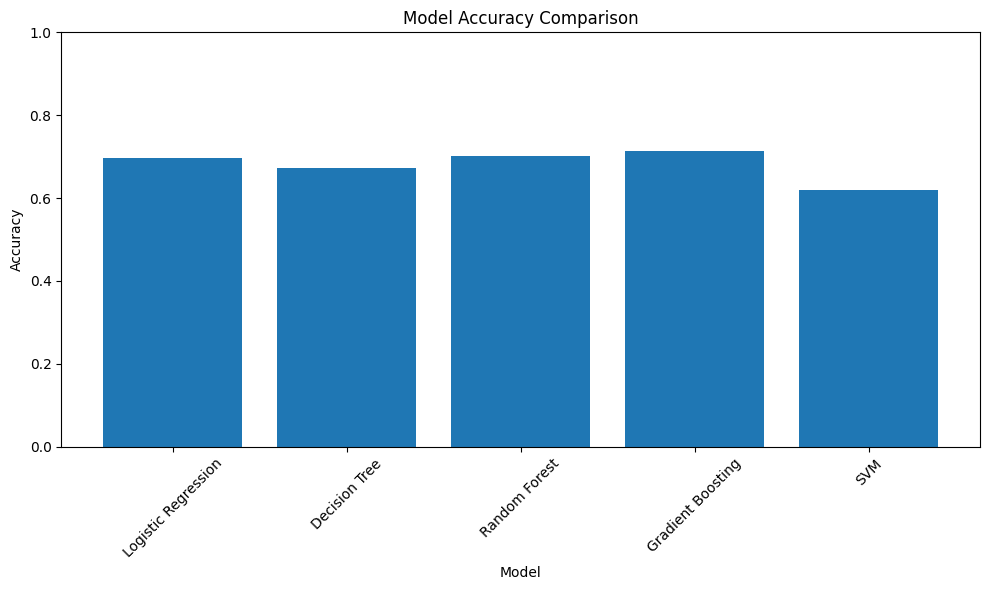

In [ ]:
accuracies = {name: results[name]['accuracy'] for name in results}
best_model_name = max(accuracies, key=accuracies.get)
best_model = results[best_model_name]['model']

print(f"\nBest performing model: {best_model_name} with accuracy {accuracies[best_model_name]:.4f}")

# Plot model comparison
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# Define parameter grid based on the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs', 'saga']
    }
elif best_model_name == 'Decision Tree':
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }

# Perform grid search
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
tuned_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
y_pred_tuned = tuned_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)

print(f"Tuned model accuracy: {accuracy_tuned:.4f}")
print("Classification Report for tuned model:")
print(report_tuned)


Performing hyperparameter tuning for Gradient Boosting...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation score: 0.7273
Tuned model accuracy: 0.6959
Classification Report for tuned model:
              precision    recall  f1-score   support

           0       0.61      0.55      0.58        65
           1       0.74      0.78      0.76       106

    accuracy                           0.70       171
   macro avg       0.68      0.67      0.67       171
weighted avg       0.69      0.70      0.69       171




Feature Importances:
TotalIncome: 0.3155
CoapplicantIncome: 0.2027
Loan_Amount_Term: 0.1666
Credit_History: 0.1418
Dependents: 0.0630
Self_Employed: 0.0497
Education: 0.0377
Married: 0.0229


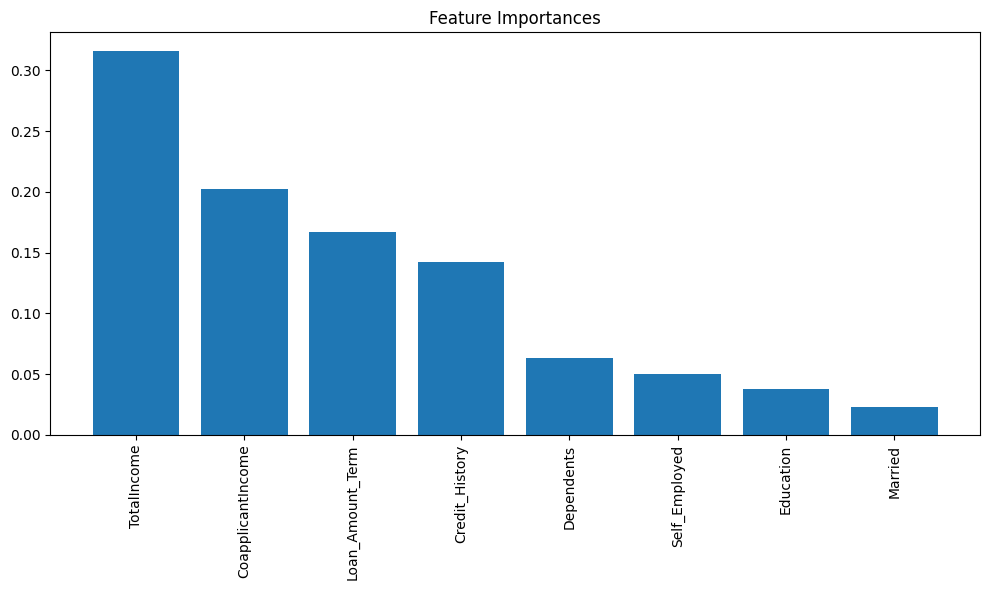

In [ ]:
# Analyze feature importance
plt.figure(figsize=(10, 6))

if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    # Tree-based models have feature_importances_
    importances = tuned_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
    plt.title('Feature Importances')

    print("\nFeature Importances:")
    for i, feature in enumerate(X_train.columns[indices]):
        print(f"{feature}: {importances[indices][i]:.4f}")

elif best_model_name == 'Logistic Regression':
    # For Logistic Regression, use coefficients
    importances = np.abs(tuned_model.coef_[0])
    indices = np.argsort(importances)[::-1]

    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
    plt.title('Feature Coefficients (absolute values)')

    print("\nFeature Coefficients (absolute values):")
    for i, feature in enumerate(X_train.columns[indices]):
        print(f"{feature}: {importances[indices][i]:.4f}")

plt.tight_layout()
plt.show()

# **Section 4: Model Testing**

In [ ]:
def predict_loan_approval(model, new_data, features=selected_features, threshold=0.7):
    """
    Predict loan approval for new application data

    Parameters:
    model: Trained model
    new_data: DataFrame containing new application data
    features: Features used in the model

    Returns:
    Predicted loan status (1 = Approved, 0 = Not Approved)
    """
    # Ensure new_data has all required features
    required_features = list(features)

    # Check if TotalIncome is in features
    if 'TotalIncome' in required_features and 'TotalIncome' not in new_data.columns:
        new_data['TotalIncome'] = new_data['ApplicantIncome'] + new_data['CoapplicantIncome']

    # Extract only the required features
    new_data_selected = new_data[required_features]

    probability = model.predict_proba(new_data_selected)[:, 1]

    # Apply custom threshold instead of using model.predict()
    prediction = (probability >= threshold).astype(int)

    return prediction, probability


In [ ]:
# Example of how to use the prediction function
print("TEST CASE 1:")
sample_application_1 = pd.DataFrame({
    'Gender': [1],  # 1 = Male, 0 = Female
    'Married': [1],  # 1 = Married, 0 = Not Married
    'Dependents': [0],  # 0 = 0 dependents, 1 = 1 dependent, 2 = 2 dependents, more than 3 = 3+ dependents
    'Education': [1],  # 1 = Graduate, 0 = Not Graduate
    'Self_Employed': [0],  # 1 = self-employed, 2 = not self-employed
    'ApplicantIncome': [5000],
    'CoapplicantIncome': [1500],
    'LoanAmount': [120],
    'Loan_Amount_Term': [360],
    'Credit_History': [1],  # 1 = good credit history
    'Property_Area': [2],  # 0 = Urban, 1 = Rural, 2 = Semiurban
    'TotalIncome': [6500]  # ApplicantIncome + CoapplicantIncome
})


# Make sure sample application has all the features used in the model
missing_features = set(selected_features) - set(sample_application_1.columns)
if missing_features:
    print(f"Warning: Sample application is missing features: {missing_features}")

# Make prediction 1 using the tuned model
prediction, probability = predict_loan_approval(tuned_model, sample_application_1, selected_features)

print("\nSample Loan Application:")
print(sample_application_1)
print(f"\nPrediction: {'Approved' if prediction[0] == 1 else 'Not Approved'}")
print(f"Probability of approval: {probability[0]:.4f}")
print("======================================================================================")


# Example of how to use the prediction function
print("TEST CASE 2:")
sample_application_2 = pd.DataFrame({
    'Gender': [0],  # 1 = Male, 0 = Female
    'Married': [0],  # 1 = Married, 0 = Not Married
    'Dependents': [1],  # 0 = 0 dependents, 1 = 1 dependent, 2 = 2 dependents, more than 3 = 3+ dependents
    'Education': [1],  # 1 = Graduate, 0 = Not Graduate
    'Self_Employed': [0],  # 1 = self-employed, 2 = not self-employed
    'ApplicantIncome': [2400],
    'CoapplicantIncome': [800],
    'LoanAmount': [300],
    'Loan_Amount_Term': [360],
    'Credit_History': [1],  # 1 = good credit history
    'Property_Area': [2],  # 0 = Urban, 1 = Rural, 2 = Semiurban
    'TotalIncome': [3200]  # ApplicantIncome + CoapplicantIncome
})


# Make sure sample application has all the features used in the model
missing_features = set(selected_features) - set(sample_application_2.columns)
if missing_features:
    print(f"Warning: Sample application is missing features: {missing_features}")

# Make prediction 1 using the tuned model
prediction, probability = predict_loan_approval(tuned_model, sample_application_2, selected_features)

print("\nSample Loan Application:")
print(sample_application_2)
print(f"\nPrediction: {'Approved' if prediction[0] == 1 else 'Not Approved'}")
print(f"Probability of approval: {probability[0]:.4f}")
print("======================================================================================")

TEST CASE 1:

Sample Loan Application:
   Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       1        1           0          1              0             5000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0               1500         120               360               1   

   Property_Area  TotalIncome  
0              2         6500  

Prediction: Approved
Probability of approval: 0.8640
TEST CASE 2:

Sample Loan Application:
   Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       0        0           1          1              0             2400   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                800         300               360               1   

   Property_Area  TotalIncome  
0              2         3200  

Prediction: Not Approved
Probability of approval: 0.4306


# **Save Model**

In [ ]:
import pickle

# Save the tuned model
with open('loan_approval_model.pkl', 'wb') as file:
    pickle.dump(tuned_model, file)

# Save the feature list
with open('model_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)

print("\nModel and features saved successfully!")


Model and features saved successfully!


In [ ]:
import pickle
import joblib
from joblib import dump

# Load the model and features from pickle files
with open("loan_approval_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)
with open("model_features.pkl", "rb") as feature_file:
    features = pickle.load(feature_file)

# Save them as joblib files
dump(model, "loan_approval_model.joblib")
dump(features, "model_features.joblib")

print("Conversion complete!")

Conversion complete!
